In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import fire
import torch
from torch.autograd import Variable
#from metric.inception_score import get_inception_score
import fw_models.dcgan as dcgan
#from progressbar import ProgressBar
import torch.nn.functional as F
from torch.utils.serialization import load_lua
from torchvision.utils import make_grid, save_image
from torch import nn
from torchvision import datasets, transforms, models
from torch.multiprocessing import Pool

import matplotlib.pyplot as plt
from collections import Counter
import cv2
import numpy as np
import matplotlib.image as mpimg
from tqdm import tqdm
from scipy import linalg
from sklearn.cluster import KMeans

In [8]:
import myfolder
import math

In [9]:
from gen_utils import *

In [10]:
celeba = myfolder.ImageFolder(root='fw_data/celeba',
                               transform=transforms.Compose([
                                   transforms.CenterCrop(138),
                                   transforms.Scale(64),
                                   transforms.ToTensor(),
#                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

/home/gh349/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


FileNotFoundError: [Errno 2] No such file or directory: 'fw_data/celeba'

In [5]:
lsun = datasets.LSUN(db_path='/scratch/gh349/lsun', classes=['bedroom_train'],
                        transform=transforms.Compose([
                            transforms.Scale(64),
                            transforms.CenterCrop(64),
                            transforms.ToTensor(),
#                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))

In [6]:
#GPU
device_id = 1

In [7]:
resnet = models.resnet34(pretrained=True).cuda(device_id).eval()
resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu,
                               resnet.maxpool, resnet.layer1,
                               resnet.layer2, resnet.layer3, resnet.layer4).cuda(device_id).eval()
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Scale(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [8]:
def get_features(imgs, batch_size=100):
    feature_conv, feature_smax, feature_class = [], [], []
    for batch in tqdm(imgs.split(batch_size)):
        batch = torch.stack(list(map(trans, batch)), 0)
        input = Variable(batch.cuda(device_id), volatile=True)
        fconv = resnet_feature(input)
        fconv = fconv.mean(3).mean(2).squeeze()
        flogit = resnet.fc(fconv)
        fsmax = F.softmax(flogit)
        feature_conv.append(fconv.data.cpu())
        feature_class.append(flogit.data.cpu())
        feature_smax.append(fsmax.data.cpu())
    feature_conv = torch.cat(feature_conv, 0)
    feature_class = torch.cat(feature_class, 0)
    feature_smax = torch.cat(feature_smax, 0)
    return feature_conv, feature_class, feature_smax

In [48]:
#def inception_score(X):
#    kl = X * (X.log() - X.mean(0).log().expand_as(X))
#    score = np.exp(kl.sum(1).mean())
#    return score

eps = 1e-8
def inception_score(X):
    kl = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score

def mode_score(X, Y):
    kl1 = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0)+eps).log()-(Y.mean(0)+eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score

def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2*m_w.dot(m) + np.trace(C + C_w - 2*C_C_w_sqrt) + eps
    return np.sqrt(score)

In [10]:
from argparse import Namespace
def knn(Mxx, Mxy, Myy, k=1, sqrt=False):

    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, largest=False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2)).float()

    s = Namespace()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp)
    s.recall = s.tp / (s.tp + s.fn)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s

In [11]:
def mmd(Mxx, Mxy, Myy, sigma):

    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(abs(Mxx.mean() + Myy.mean() - 2 * Mxy.mean()))

    return mmd


In [12]:
import ot
def wasserstein(Mxy, sqrt=True):
    M = Mxy.abs().sqrt() if sqrt else Mxy
    emd = ot.emd2([], [], M.numpy())
    return emd

In [13]:
def collapse_score(r_feat, c_feat, pred):
    n_mode = c_feat.size(0)
    # emd, mmd, acc_t, acc_f
    c_feat_repeat = c_feat[pred]
    scores = np.zeros((n_mode, 4))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    Mxx = l2dist(r_feat, r_feat, sqrt=True)
    for i in range(n_mode):
        c = collapsed_order[i]
        cidx = index[pred.eq(c)]
        t_feat[cidx] = c_feat_repeat[cidx]
        Mxy = l2dist(r_feat, t_feat, sqrt=True)
        Myy = l2dist(t_feat, t_feat, sqrt=True)
        scores[i, 0] = wasserstein(Mxy, False)
        scores[i, 1] = mmd(Mxx, Mxy, Myy, 1)
        s = knn(Mxx, Mxy, Myy)
        scores[i, 2], scores[i, 3] = s.acc_t, s.acc_f
        if i % 10 == 9:
            print(i, scores[i].tolist())
    return scores

In [14]:
def collapse_score_val(r_feat_val, r_feat, c_feat, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = c_feat.size(0)
    c_feat_repeat = c_feat[pred]
    scores = np.zeros((n_mode, 4))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    Mxx = l2dist(r_feat_val, r_feat_val, sqrt=False)
    for i in range(n_mode):
        Mxy = l2dist(r_feat_val, t_feat, sqrt=False)
        Myy = l2dist(t_feat, t_feat, sqrt=False)
        scores[i, 0] = wasserstein(Mxy, True)
        scores[i, 1] = mmd(Mxx, Mxy, Myy, 1)
        s = knn(Mxx, Mxy, Myy)
        scores[i, 2], scores[i, 3] = s.acc_t, s.acc_f
        if i % 10 == 9:
            print(i, scores[i].tolist())
        c = collapsed_order[i]
        cidx = index[pred.eq(c)]
        t_feat[cidx] = c_feat_repeat[cidx]
    return scores

In [15]:
def collapse_inception_score(r_feat, c_feat, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = c_feat.size(0)
    c_feat_repeat = c_feat[pred]
    scores = np.zeros((n_mode))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    for i in range(n_mode):
        scores[i] = inception_score(t_feat)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        c = collapsed_order[i]
        cidx = index[pred.eq(c)]
        t_feat[cidx] = c_feat_repeat[cidx]
    return scores

In [16]:
def collapse_mode_score(r_feat, r_feat2, c_feat, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = c_feat.size(0)
    c_feat_repeat = c_feat[pred]
    scores = np.zeros((n_mode))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    for i in range(n_mode):
        scores[i] = mode_score(t_feat, r_feat2)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        c = collapsed_order[i]
        cidx = index[pred.eq(c)]
        t_feat[cidx] = c_feat_repeat[cidx]
    return scores

In [17]:
def collapse_fid(r_feat, r_feat2, c_feat, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = c_feat.size(0)
    c_feat_repeat = c_feat[pred]
    scores = np.zeros((n_mode))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    for i in range(n_mode):
        scores[i] = fid(t_feat, r_feat2)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        c = collapsed_order[i]
        cidx = index[pred.eq(c)]
        t_feat[cidx] = c_feat_repeat[cidx]
    return scores

In [18]:
def dropping_score_val(r_feat_val, r_feat_train, pred):
    # emd, mmd, acc_t, acc_f
#     c_feat_repeat = c_feat[pred]
    n_mode = len(Counter(pred))
    scores = np.zeros((n_mode, 4))
    t_feat = r_feat_train.clone()
    collapsed_order = torch.randperm(n_mode).long()
    index = torch.arange(0, r_feat_train.size(0)).long()
    collapsed = torch.zeros(r_feat_train.size(0)).byte()
    Mxx = l2dist(r_feat_val, r_feat_val, sqrt=True)
    for i in range(n_mode):
        Mxy = l2dist(r_feat_val, t_feat, sqrt=True)
        Myy = l2dist(t_feat, t_feat, sqrt=True)
#         print(Mxy.max(), Mxy.min())
        scores[i, 0] = wasserstein(Mxy, False)
        scores[i, 1] = mmd(Mxx, Mxy, Myy, 1)
        s = knn(Mxx, Mxy, Myy)
        scores[i, 2], scores[i, 3] = s.acc_t, s.acc_f
        if i % 10 == 9:
            print(i, scores[i].tolist())
        
        c = collapsed_order[i]
        collapsed[pred.eq(c)] = 1
        cidx = index[collapsed.eq(1)]
        ncidx = index[collapsed.ne(1)]
        if ncidx.dim() == 0:
            continue
        if cidx.dim() == 0:
            continue
        for i in cidx:
            j = np.random.randint(0, ncidx.size(0))
            t_feat[i] = t_feat[ncidx[j]]
    return scores

In [19]:
def drop_inception_score(r_feat, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = len(Counter(pred))
    scores = np.zeros((n_mode))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    collapsed = torch.zeros(r_feat.size(0)).byte()
    for i in range(n_mode):
        scores[i] = inception_score(t_feat)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        
        c = collapsed_order[i]
        collapsed[pred.eq(c)] = 1
        cidx = index[collapsed.eq(1)]
        ncidx = index[collapsed.ne(1)]
        if ncidx.dim() == 0:
            continue
        if cidx.dim() == 0:
            continue
        for i in cidx:
            j = np.random.randint(0, ncidx.size(0))
            t_feat[i] = t_feat[ncidx[j]]
    return scores

In [20]:
def drop_mode_score(r_feat, r_feat2, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = len(Counter(pred))
    scores = np.zeros((n_mode))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    collapsed = torch.zeros(r_feat.size(0)).byte()
    for i in range(n_mode):
        scores[i] = mode_score(t_feat, r_feat2)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        
        c = collapsed_order[i]
        collapsed[pred.eq(c)] = 1
        cidx = index[collapsed.eq(1)]
        ncidx = index[collapsed.ne(1)]
        if ncidx.dim() == 0:
            continue
        if cidx.dim() == 0:
            continue
        for i in cidx:
            j = np.random.randint(0, ncidx.size(0))
            t_feat[i] = t_feat[ncidx[j]]
    return scores

In [21]:
def drop_fid(r_feat, r_feat2, pred):
    # emd, mmd, acc_t, acc_f
    n_mode = len(Counter(pred))
    scores = np.zeros((n_mode))
    t_feat = r_feat.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    collapsed = torch.zeros(r_feat.size(0)).byte()
    for i in range(n_mode):
        scores[i] = fid(t_feat, r_feat2)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        
        c = collapsed_order[i]
        collapsed[pred.eq(c)] = 1
        cidx = index[collapsed.eq(1)]
        ncidx = index[collapsed.ne(1)]
        if ncidx.dim() == 0:
            continue
        if cidx.dim() == 0:
            continue
        for i in cidx:
            j = np.random.randint(0, ncidx.size(0))
            t_feat[i] = t_feat[ncidx[j]]
    return scores

In [22]:
def overfitting_score_val(r_feat_val, r_feat_train, step=200):
    # emd, mmd, acc_t, acc_f
#     c_feat_repeat = c_feat[pred]
    n_mode = r_feat_train.size(0) // step
    scores = np.zeros((n_mode+1, 4))
    t_feat = r_feat_train.clone()
    collapsed_order = torch.randperm(n_mode).long()
    index = torch.arange(0, r_feat_train.size(0)).long()
    collapsed = torch.zeros(r_feat_train.size(0)).byte()
    Mxx = l2dist(r_feat_val, r_feat_val, sqrt=True)
    for i in range(n_mode+1):
        Mxy = l2dist(r_feat_val, t_feat, sqrt=True)
        Myy = l2dist(t_feat, t_feat, sqrt=True)
#         print(Mxy.max(), Mxy.min())
        scores[i, 0] = wasserstein(Mxy, False)
        scores[i, 1] = mmd(Mxx, Mxy, Myy, 1)
        s = knn(Mxx, Mxy, Myy)
        scores[i, 2], scores[i, 3] = s.acc_t, s.acc_f
        if i % 10 == 9:
            print(i, scores[i].tolist())
        if i == n_mode:
            break
        t_feat[i*step:(i+1)*step] = r_feat_val[i*step:(i+1)*step]
    
    return scores

In [23]:
def overfit_inception_score(r_feat_val, r_feat_train, step=200):
    # emd, mmd, acc_t, acc_f
    n_mode = r_feat_train.size(0) // step
    scores = np.zeros((n_mode+1))
    t_feat = r_feat_train.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    collapsed = torch.zeros(r_feat_train.size(0)).byte()
    for i in range(n_mode+1):
        scores[i] = inception_score(t_feat)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        if i == n_mode:
            break
        t_feat[i*step:(i+1)*step] = r_feat_val[i*step:(i+1)*step]
    return scores

In [24]:
def overfit_mode_score(r_feat_val, r_feat_train, step=200):
    # emd, mmd, acc_t, acc_f
    n_mode = r_feat_train.size(0) // step
    scores = np.zeros((n_mode+1))
    t_feat = r_feat_train.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    collapsed = torch.zeros(r_feat_train.size(0)).byte()
    for i in range(n_mode+1):
        scores[i] = mode_score(t_feat, r_feat_train)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        if i == n_mode:
            break
        t_feat[i*step:(i+1)*step] = r_feat_val[i*step:(i+1)*step]
    return scores

In [25]:
def overfit_fid(r_feat_val, r_feat_train, step=200):
    # emd, mmd, acc_t, acc_f
    n_mode = r_feat_train.size(0) // step
    scores = np.zeros((n_mode+1))
    t_feat = r_feat_train.clone()
    index = torch.arange(0, 2000).long()
    collapsed_order = torch.randperm(n_mode).long()
    collapsed = torch.zeros(r_feat_train.size(0)).byte()
    for i in range(n_mode+1):
        scores[i] = fid(t_feat, r_feat_train)
        if i % 10 == 9:
            print(i, scores[i].tolist())
        if i == n_mode:
            break
        t_feat[i*step:(i+1)*step] = r_feat_val[i*step:(i+1)*step]
    return scores

In [56]:
def get_score(Mxx, Mxy, Myy):
    scores = [0]*4
    scores[0] = wasserstein(Mxy, False)
    scores[1] = mmd(Mxx, Mxy, Myy, 1)
    s = knn(Mxx, Mxy, Myy)
    scores[2], scores[3] = s.acc_t, s.acc_f
    #print(scores)
    return scores

def get_score_1(s_g, s_true):
    scores = [0]*3
    scores[0] = inception_score(s_g)
    scores[1] = mode_score(s_g, s_true)
    scores[2] = fid(s_g, s_true)
    return scores
        
def overfitting_score_4(r_feat_val, r_feat_train, step=200):
    n_mode = r_feat_train.size(0) // step
    scores_val = np.zeros((n_mode+1, 4))
    scores_tr = np.zeros((n_mode+1, 4))
    t_feat = r_feat_val.clone()
    
    
    Mxx = l2dist(r_feat_val, r_feat_val, sqrt=True)
    Mxx_tr = l2dist(r_feat_train, r_feat_train, sqrt=True)
    for i in range(n_mode+1):
        Mxy = l2dist(r_feat_val, t_feat, sqrt=True)
        Myy = l2dist(t_feat, t_feat, sqrt=True)        
        scores_val[i,:] = get_score(Mxx, Mxy, Myy)
        
        Mxy = l2dist(r_feat_train, t_feat, sqrt=True)
        scores_tr[i,:] = get_score(Mxx_tr, Mxy, Myy)
        
        #if i % 10 == 9:
        #    print(i, scores[i].tolist())
        if i == n_mode:
            break
        t_feat[i*step:(i+1)*step] = r_feat_train[i*step:(i+1)*step]
    
    #print(scores_val - scores_tr) 
    return scores_val - scores_tr
def overfitting_score_3(r_feat_val, r_feat_train, step=200):
    n_mode = r_feat_train.size(0) // step
    scores_val = np.zeros((n_mode+1, 3))
    scores_tr = np.zeros((n_mode+1, 3))
    t_feat = r_feat_val.clone()
    
    
    for i in range(n_mode+1):        
        scores_val[i,:] = get_score_1(t_feat, r_feat_val)
        scores_tr[i,:] = get_score_1(t_feat, r_feat_train)
        
        #if i % 10 == 9:
        #    print(i, scores[i].tolist())
        if i == n_mode:
            break
        t_feat[i*step:(i+1)*step] = r_feat_train[i*step:(i+1)*step]
    
    return scores_val[:,0] - scores_tr[:,0], scores_val[:,1] - scores_tr[:,1], scores_val[:,2] - scores_tr[:,2] 

In [61]:
def run_overfit_exps(ntimes=5):
    for i in range(0):
        print('ITER={}'.format(i))
        real_idx = torch.randperm(len(celeba)).long()
        r_imgs = torch.stack([celeba[i][0] for i in tqdm(real_idx[:2000])], 0)
        r2_imgs = torch.stack([celeba[i][0] for i in tqdm(real_idx[2000:4000])], 0)
        kmeans = KMeans(n_clusters=50, n_jobs=12)
        X = r_imgs.view(2000, -1).numpy()
        kmeans.fit(X)
        centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 3, 64, 64).float()
        r_feat = get_features(r_imgs)
        r2_feat = get_features(r2_imgs)
        c_feat = get_features(centers)
        pred = l2dist(r_imgs, centers).min(1)[1].squeeze_()

        path = '../data/repo/rlt/fw_data/new_celeba_overfit_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = overfitting_score_4(r2_imgs, r_imgs)
            conv_scores = overfitting_score_4(r2_feat[0], r_feat[0])
            incept_scores,mode_scores,Fid = overfitting_score_3(r2_feat[2], r_feat[2])
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)
            
            
    for i in range(5):
        print('ITER={}'.format(i))
        real_idx = torch.randperm(len(lsun)).long()
        r_imgs = torch.stack([lsun[i][0] for i in tqdm(real_idx[:2000])], 0)
        r2_imgs = torch.stack([lsun[i][0] for i in tqdm(real_idx[2000:4000])], 0)
        kmeans = KMeans(n_clusters=50, n_jobs=12)
        X = r_imgs.view(2000, -1).numpy()
        kmeans.fit(X)
        centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 3, 64, 64).float()
        r_feat = get_features(r_imgs)
        r2_feat = get_features(r2_imgs)
        c_feat = get_features(centers)
        pred = l2dist(r_imgs, centers).min(1)[1].squeeze_()
        
        path = '../data/repo/rlt/fw_data/new_lsun_overfit_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = overfitting_score_4(r2_imgs, r_imgs)
            conv_scores = overfitting_score_4(r2_feat[0], r_feat[0])
            incept_scores,mode_scores,Fid = overfitting_score_3(r2_feat[2], r_feat[2])
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)

In [62]:
run_overfit_exps()

  0%|          | 0/2000 [00:00<?, ?it/s]

ITER=0


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


[0.013880728743970394, 0.0, 0.0, 0.0]
[26.184497833251953, 0.018821645468586876, 0.441, 0.559]
[4.342059135437012, 0.006018023172639402, 0.053, 0.045]
[24.113435745239258, 0.017509381768421504, 0.4155, 0.4845]
[7.369998455047607, 0.009378939556252274, 0.109, 0.0975]
[21.917898178100586, 0.015805076775350587, 0.372, 0.4375]
[10.209293365478516, 0.010926649194519524, 0.164, 0.1445]
[19.651071548461914, 0.01497152724763013, 0.321, 0.381]
[13.045191764831543, 0.013191485299678453, 0.213, 0.1885]
[17.362525939941406, 0.013904946511232518, 0.275, 0.321]
[15.415915489196777, 0.013949214391839241, 0.267, 0.244]
[15.174521446228027, 0.01272003228081817, 0.241, 0.273]
[17.68844985961914, 0.015348751043873416, 0.335, 0.2815]
[12.664483070373535, 0.012307116181299774, 0.2055, 0.204]
[20.107650756835938, 0.01645373633032979, 0.3825, 0.3285]
[9.697309494018555, 0.010588455611198807, 0.1395, 0.166]
[22.438486099243164, 0.017571223651542515, 0.449, 0.3785]
[6.824507236480713, 0.008529057969584725, 0.0

  2%|▏         | 34/2000 [00:00<00:05, 336.56it/s]

ITER=1


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


[0.012989358976483345, 0.0, 0.0, 0.0]
[26.408824920654297, 0.018780074830786964, 0.5055, 0.46]
[4.36842155456543, 0.00626855274776136, 0.0505, 0.049]
[24.421586990356445, 0.017565216359013276, 0.4605, 0.4115]
[7.372920989990234, 0.00913873440965436, 0.097, 0.1035]
[22.373197555541992, 0.016440151350240493, 0.406, 0.3735]
[10.047284126281738, 0.010888155579242402, 0.1425, 0.15]
[19.85977554321289, 0.015377533253540743, 0.3535, 0.3365]
[12.776103973388672, 0.013068564191170483, 0.1735, 0.2215]
[17.742509841918945, 0.014385997427870032, 0.291, 0.295]
[15.493868827819824, 0.014450490608353413, 0.2255, 0.2605]
[15.389158248901367, 0.013089047787392822, 0.248, 0.25]
[17.67081642150879, 0.015004388654210579, 0.2785, 0.31]
[12.780560493469238, 0.012108333678538804, 0.1975, 0.2045]
[19.99753761291504, 0.015666053950505847, 0.3085, 0.368]
[9.985065460205078, 0.010553406261034856, 0.149, 0.157]
[22.400697708129883, 0.016718583156071613, 0.354, 0.4215]
[6.795366287231445, 0.008548807768159215, 0.0

  1%|          | 21/2000 [00:00<00:09, 202.34it/s]

ITER=2


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


[0.013005849905312061, 0.0, 0.0, 0.0]
[26.49718475341797, 0.01973138521841925, 0.543, 0.454]
[4.495577335357666, 0.005963756389727921, 0.052, 0.0575]
[24.242454528808594, 0.018653270359686308, 0.4835, 0.407]
[7.628979682922363, 0.008569029936371765, 0.0825, 0.115]
[21.96137237548828, 0.01715489171228801, 0.424, 0.3845]
[10.295771598815918, 0.010661792811226065, 0.1285, 0.172]
[20.0671443939209, 0.01606998064990413, 0.3575, 0.3585]
[13.0735502243042, 0.012443897414713155, 0.178, 0.2155]
[17.58740997314453, 0.014510165865380646, 0.3065, 0.3035]
[15.685490608215332, 0.014594921514052239, 0.2265, 0.275]
[15.171419143676758, 0.013208179192405897, 0.261, 0.2465]
[18.097335815429688, 0.016774962877126712, 0.2725, 0.3315]
[12.872603416442871, 0.011795659301019, 0.207, 0.196]
[20.478322982788086, 0.01908480117591181, 0.323, 0.3905]
[9.761564254760742, 0.011156717132026832, 0.151, 0.152]
[22.616243362426758, 0.018571454274441894, 0.388, 0.412]
[6.857105731964111, 0.008318632207805383, 0.1065, 0.

  1%|▏         | 28/2000 [00:00<00:07, 273.77it/s]

ITER=3


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


[0.013177968561649323, 0.0, 0.0, 0.0]
[26.54575538635254, 0.021511808270864467, 0.4605, 0.507]
[4.361573219299316, 0.007352975210977846, 0.046, 0.0565]
[24.530635833740234, 0.018910289167815928, 0.4175, 0.463]
[7.131607532501221, 0.00923148082466846, 0.1055, 0.097]
[22.317472457885742, 0.017937545485555272, 0.38, 0.414]
[10.20185661315918, 0.010943603597658683, 0.162, 0.143]
[20.24599266052246, 0.01820697565321635, 0.3455, 0.36]
[12.921478271484375, 0.012099199953148865, 0.223, 0.185]
[17.61668586730957, 0.017308658881680736, 0.296, 0.3035]
[15.62752914428711, 0.01308931877861398, 0.2445, 0.246]
[15.37307357788086, 0.015685056529106692, 0.242, 0.2565]
[18.27361297607422, 0.014992925352181219, 0.2905, 0.289]
[12.772696495056152, 0.013402795933547824, 0.202, 0.2005]
[20.475509643554688, 0.015535410541085396, 0.358, 0.3255]
[9.897981643676758, 0.012496944052745484, 0.154, 0.148]
[22.634092330932617, 0.016647740714896973, 0.405, 0.3805]
[6.763713359832764, 0.01052256596524295, 0.1025, 0.09

  2%|▏         | 34/2000 [00:00<00:05, 337.93it/s]

ITER=4


100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


[0.014116385020315647, 0.0, 0.0, 0.0]
[26.394868850708008, 0.018422439943068854, 0.576, 0.4335]
[4.493245601654053, 0.005843740519323258, 0.0455, 0.0545]
[24.25754165649414, 0.017443723127643026, 0.492, 0.397]
[7.368522644042969, 0.008376617969702843, 0.094, 0.1075]
[22.014739990234375, 0.016128738372194182, 0.435, 0.359]
[10.437311172485352, 0.011010233512680509, 0.1465, 0.166]
[19.742263793945312, 0.015513722257937786, 0.3955, 0.306]
[12.884493827819824, 0.012575188826295521, 0.185, 0.23]
[17.58775520324707, 0.014403678519988257, 0.3145, 0.2785]
[15.608451843261719, 0.014344040658648914, 0.2435, 0.272]
[15.281686782836914, 0.014237945567857586, 0.2845, 0.223]
[17.9914608001709, 0.015821108422208904, 0.266, 0.3215]
[12.487306594848633, 0.013059168680000125, 0.2085, 0.185]
[20.379287719726562, 0.0179669017100331, 0.316, 0.396]
[9.721273422241211, 0.012819008708898575, 0.152, 0.143]
[22.332639694213867, 0.01717842000837046, 0.357, 0.444]
[6.990662574768066, 0.008805745332906185, 0.109, 

In [26]:
def get_scores(r_feat, t_feat):
    Mxx = l2dist(r_feat, r_feat, sqrt=False)
    Mxy = l2dist(r_feat, t_feat, sqrt=False)
    Myy = l2dist(t_feat, t_feat, sqrt=False)
    emd_s = wasserstein(Mxy, True)
    mmd_s = mmd(Mxx, Mxy, Myy, 1)
    s = knn(Mxx, Mxy, Myy)
    return emd_s, mmd_s, s.acc_t, s.acc_f

In [27]:
import os

In [30]:
def l2dist(X, Y, sqrt=True, batch_size=5000):
    #nX = X.size(0)
    #nY = Y.size(0)
    #X = X.view(nX, -1)
    #Y = Y.view(nY, -1)
    #M = torch.zeros(nX, nY)
    #for i in range(0, nX, batch_size):
    #    bsX = min(batch_size, nX - i)
    #    for j in range(0, nY, batch_size):
    #        bsY = min(batch_size, nY - j)
    #        thisX = X[i:i+bsX].cuda(device_id)
    #        thisY = Y[j:j+bsY].cuda(device_id)
    #        X2 = (thisX * thisX).sum(1)
    #        Y2 = (thisY * thisY).sum(1)
    #        tmp = X2.expand(bsX, bsY) + Y2.expand(bsY, bsX).transpose(0, 1) - 2 * torch.mm(thisX, thisY.transpose(0, 1))
    #        if sqrt:
    #            tmp.abs_().sqrt_()
    #        M[i:i+bsX, j:j+bsY].copy_(tmp)
    #
    #return M

    nX = X.size(0)
    nY = Y.size(0)
    M = torch.zeros(nX, nY)
    #X = X.view(nX,-1).cuda(2)
    X = X.view(nX,-1)
    X2 = (X*X).sum(1).resize_(nX,1)
    #Y = Y.view(nY,-1).cuda(2)
    Y = Y.view(nY,-1)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1))
    #M.copy_(X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1)))
    del X, X2, Y, Y2
    
    if sqrt:
        M = ((M+M.abs())/2).sqrt()
    
    return M

In [34]:
def run_celeba_exps(ntimes=5):
    for i in range(5):
        print('ITER={}'.format(i))
        real_idx = torch.randperm(len(celeba)).long()
        r_imgs = torch.stack([celeba[i][0] for i in tqdm(real_idx[:2000])], 0)
        r2_imgs = torch.stack([celeba[i][0] for i in tqdm(real_idx[2000:4000])], 0)
        kmeans = KMeans(n_clusters=50, n_jobs=12)
        X = r_imgs.view(2000, -1).numpy()
        kmeans.fit(X)
        centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 3, 64, 64).float()
        r_feat = get_features(r_imgs)
        r2_feat = get_features(r2_imgs)
        c_feat = get_features(centers)
        pred = l2dist(r_imgs, centers).min(1)[1].squeeze_()
        path = '../data/repo/rlt/fw_data/celeba_collapse_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = collapse_score_val(r2_imgs, r_imgs, centers, pred)
            conv_scores = collapse_score_val(r2_feat[0], r_feat[0], c_feat[0], pred)
            incept_scores = collapse_inception_score(r_feat[2], c_feat[2], pred)
            mode_scores = collapse_mode_score(r2_feat[2], r_feat[2], c_feat[2], pred)
            Fid = collapse_fid(r2_feat[2], r_feat[2], c_feat[2], pred)
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)
        path = '../data/repo/rlt/fw_data/celeba_drop_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = dropping_score_val(r2_imgs, r_imgs, pred)
            conv_scores = dropping_score_val(r2_feat[0], r_feat[0], pred)
            incept_scores = drop_inception_score(r_feat[2], pred)
            mode_scores = drop_mode_score(r2_feat[2], r_feat[2], pred)
            Fid = drop_fid(r2_feat[2], r_feat[2], pred)
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)
        path = '../data/repo/rlt/fw_data/celeba_overfit_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = overfitting_score_val(r2_imgs, r_imgs)
            conv_scores = overfitting_score_val(r2_feat[0], r_feat[0])
            incept_scores = overfit_inception_score(r2_feat[2], r_feat[2])
            mode_scores = overfit_mode_score(r2_feat[2], r_feat[2])
            Fid = overfit_fid(r2_feat[2], r_feat[2])
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)
        

In [35]:
def run_lsun_exps(ntimes=5):
    for i in range(5):
        print('ITER={}'.format(i))
        real_idx = torch.randperm(len(lsun)).long()
        r_imgs = torch.stack([lsun[i][0] for i in tqdm(real_idx[:2000])], 0)
        r2_imgs = torch.stack([lsun[i][0] for i in tqdm(real_idx[2000:4000])], 0)
        kmeans = KMeans(n_clusters=50, n_jobs=12)
        X = r_imgs.view(2000, -1).numpy()
        kmeans.fit(X)
        centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 3, 64, 64).float()
        r_feat = get_features(r_imgs)
        r2_feat = get_features(r2_imgs)
        c_feat = get_features(centers)
        pred = l2dist(r_imgs, centers).min(1)[1].squeeze_()
        path = '../data/repo/rlt/fw_data/lsun_collapse_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = collapse_score_val(r2_imgs, r_imgs, centers, pred)
            conv_scores = collapse_score_val(r2_feat[0], r_feat[0], c_feat[0], pred)
            incept_scores = collapse_inception_score(r_feat[2], c_feat[2], pred)
            mode_scores = collapse_mode_score(r2_feat[2], r_feat[2], c_feat[2], pred)
            Fid = collapse_fid(r2_feat[2], r_feat[2], c_feat[2], pred)
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)
        path = '../data/repo/rlt/fw_data/lsun_drop_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = dropping_score_val(r2_imgs, r_imgs, pred)
            conv_scores = dropping_score_val(r2_feat[0], r_feat[0], pred)
            incept_scores = drop_inception_score(r_feat[2], pred)
            mode_scores = drop_mode_score(r2_feat[2], r_feat[2], pred)
            Fid = drop_fid(r2_feat[2], r_feat[2], pred)
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)
        path = '../data/repo/rlt/fw_data/lsun_overfit_scores_{}.pth'.format(i)
        if not os.path.exists(path):
            pix_scores = overfitting_score_val(r2_imgs, r_imgs)
            conv_scores = overfitting_score_val(r2_feat[0], r_feat[0])
            incept_scores = overfit_inception_score(r2_feat[2], r_feat[2])
            mode_scores = overfit_mode_score(r2_feat[2], r_feat[2])
            Fid = overfit_fid(r2_feat[2], r_feat[2])
            torch.save([pix_scores, conv_scores, incept_scores, mode_scores, Fid], path)

In [36]:
run_celeba_exps(5)

  1%|          | 22/2000 [00:00<00:09, 213.33it/s]

ITER=0


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


9 [23.001916885375977, 0.027509334071695042, 0.563, 0.641]
19 [23.358362197875977, 0.03687745386279318, 0.6535, 0.8055]
29 [23.968807220458984, 0.042803358305923196, 0.7455, 0.943]
39 [24.7767333984375, 0.06781073552727933, 0.859, 0.9985]
49 [41.904930114746094, 0.4548176470265581, 0.992, 1.0]
9 [9.8731107711792, 0.02265221638091783, 0.546, 0.6445]
19 [9.849811553955078, 0.024426112702422436, 0.6035, 0.777]
29 [9.882355690002441, 0.02677562643480617, 0.6635, 0.907]
39 [9.87115478515625, 0.03835226654336215, 0.7725, 0.992]
49 [11.009897232055664, 0.1501698977547921, 0.9765, 1.0]
9 2.4195885806178774
19 2.359661288716765
29 2.245222618485197
39 2.212136830223557
49 2.0283931320340245
9 2.3678927609507947
19 2.3822442010068126
29 2.388266936238586
39 2.3006209113502023
49 1.760797463149551
9 0.07593438614251073
19 0.07905845407594009
29 0.08740303566949154
39 0.08597700867097847
49 0.20025499009371797
9 [3.5741231441497803, 0.007347731047388252, 0.0535, 0.048]
9 [1.5245943069458008, 0.006

/home/gh349/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


9 0.05806741203900737


  1%|          | 23/2000 [00:00<00:08, 222.72it/s]

ITER=1


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


9 [22.22945213317871, 0.03169173893523975, 0.4525, 0.598]
19 [21.555740356445312, 0.04967885679349613, 0.418, 0.693]
29 [20.908992767333984, 0.06822414473789219, 0.4015, 0.794]
39 [20.398853302001953, 0.08581378491366891, 0.3795, 0.8895]
49 [19.85283660888672, 0.10658895729294852, 0.382, 0.991]
9 [10.034379005432129, 0.07458678047446232, 0.5625, 0.5425]
19 [10.44680404663086, 0.1448575657138347, 0.6465, 0.616]
29 [10.95559024810791, 0.22097906862687847, 0.743, 0.716]
39 [11.451562881469727, 0.2936381086273326, 0.8305, 0.848]
49 [11.972665786743164, 0.3606493739616103, 0.9815, 0.983]
9 2.266853559591185
19 1.988464187718004
29 1.807651220979034
39 1.597663303315494
49 1.3338808549186125
9 2.2606298850817166
19 1.9388661718556581
29 1.6451200886880375
39 1.3318269820887685
49 1.0614890941870154
9 0.07339841026263572
19 0.0921421608930352
29 0.12095449195822214
39 0.17282480242092835
49 0.24324349425600095
9 [22.862817764282227, 0.026223012501836007, 0.5225, 0.6555]
19 [23.09793472290039,

  1%|▏         | 27/2000 [00:00<00:07, 264.84it/s]

ITER=2


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


9 [22.388324737548828, 0.020596936250835994, 0.4585, 0.549]
19 [21.680145263671875, 0.036363156799130256, 0.4225, 0.6685]
29 [20.935592651367188, 0.05787869585453126, 0.404, 0.78]
39 [20.401763916015625, 0.07770743661194246, 0.372, 0.88]
49 [19.83510971069336, 0.09763453310317129, 0.3485, 0.9895]
9 [10.137267112731934, 0.06604747410366167, 0.528, 0.565]
19 [10.592955589294434, 0.15426822037209043, 0.612, 0.6555]
29 [11.05935287475586, 0.22654551112617818, 0.693, 0.7265]
39 [11.54023265838623, 0.29608292301316375, 0.822, 0.8365]
49 [11.784841537475586, 0.36267395625105947, 0.971, 0.982]
9 2.280576364393108
19 2.0558961505790183
29 1.7606108563873564
39 1.4614100303790423
49 1.2849451746160212
9 2.2737125575181016
19 1.9499202565057916
29 1.6633187306870525
39 1.3420911728534042
49 1.0511552271369897
9 0.07493594488354763
19 0.09296488326725107
29 0.12223393632791232
39 0.1706231853769678
49 0.2481743750601337
9 [23.20977210998535, 0.03134528874426244, 0.5775, 0.659]
19 [23.6427783966064

  0%|          | 7/2000 [00:00<00:29, 68.50it/s]

ITER=3


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


9 [22.18219757080078, 0.027809861785749426, 0.461, 0.5865]
19 [21.4534912109375, 0.047236332456379614, 0.4175, 0.707]
29 [20.876298904418945, 0.06574136934349192, 0.404, 0.7885]
39 [20.25211524963379, 0.08574299156066187, 0.393, 0.905]
49 [19.903587341308594, 0.10230011227142606, 0.387, 0.9915]
9 [10.086055755615234, 0.05745151562726449, 0.5295, 0.539]
19 [10.504190444946289, 0.14623438115151893, 0.6145, 0.616]
29 [10.85342788696289, 0.204694090833208, 0.6845, 0.6865]
39 [11.365779876708984, 0.279103375828377, 0.826, 0.8205]
49 [11.971145629882812, 0.3678734113931244, 0.9795, 0.983]
9 2.1731166556529495
19 1.9725863978924254
29 1.7884692677328855
39 1.533043893891623
49 1.292425374590026
9 2.207640626324999
19 1.967152545057495
29 1.6521474527619637
39 1.3743716658776903
49 1.0577148584435716
9 0.07641090496485424
19 0.1042381808580208
29 0.1360109192271237
39 0.175342683949323
49 0.23004396196231253
9 [22.939952850341797, 0.02741617395771081, 0.55, 0.619]
19 [23.32266616821289, 0.0372

  0%|          | 0/2000 [00:00<?, ?it/s]

ITER=4


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


9 [22.452796936035156, 0.025813000363078265, 0.4645, 0.58]
19 [21.74798583984375, 0.042797330673060095, 0.4325, 0.691]
29 [21.116439819335938, 0.06281496393613388, 0.4055, 0.796]
39 [20.671586990356445, 0.07807450460260627, 0.4, 0.864]
49 [20.085556030273438, 0.1014686878802472, 0.392, 0.9825]
9 [9.993603706359863, 0.07175412348313259, 0.553, 0.541]
19 [10.468049049377441, 0.15117525573154358, 0.6225, 0.628]
29 [10.939626693725586, 0.23079296861643503, 0.737, 0.7385]
39 [11.446335792541504, 0.2934945705230832, 0.838, 0.8455]
49 [11.898685455322266, 0.3597497790892258, 0.9805, 0.9825]
9 2.270485832776444
19 1.9944239612954342
29 1.814868763462609
39 1.5732616671359594
49 1.3644864127617033
9 2.2102946087137507
19 1.8968145217337748
29 1.6352226730367756
39 1.3506617910985756
49 1.10649515745846
9 0.07498437276960716
19 0.09588137343797044
29 0.12181733132777955
39 0.149121262729924
49 0.21531226122416877
9 [23.179441452026367, 0.033142330188648414, 0.5575, 0.6645]
19 [23.65452766418457,

In [101]:
data = 'celeba'
for t in ['collapse', 'drop', 'overfit']:
    template = 'data/celeba_{}_scores'.format(t)
    scores = [[], [], []]
    for i in range(5):
        s = torch.load(template + '_{}.pth'.format(i))
        for j in range(3):
            scores[j].append(torch.from_numpy(s[j]))
    for j in range(3):
        scores[j] = torch.stack(scores[j], 0)
        if scores[j].dim() == 3 and scores[j].size(2) == 4:
            scores[j] = torch.cat([scores[j][:, :, :2], scores[j][:, :, 2:].mean(2), scores[j][:, :, 2:]], 2)
        print(scores[j].size())
    torch.save(scores, template + '.pth')

torch.Size([5, 50, 5])
torch.Size([5, 50, 5])
torch.Size([5, 50])
torch.Size([5, 50, 5])
torch.Size([5, 50, 5])
torch.Size([5, 50])
torch.Size([5, 11, 5])
torch.Size([5, 11, 5])
torch.Size([5, 11])


In [37]:
run_lsun_exps(5)

  1%|▏         | 26/2000 [00:00<00:07, 255.17it/s]

ITER=0


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


9 [25.658546447753906, 0.02850219789639727, 0.376, 0.652]
19 [24.755207061767578, 0.047785021097716776, 0.3215, 0.739]
29 [23.67010498046875, 0.07740180977038756, 0.2495, 0.8515]
39 [22.699443817138672, 0.10245272764474227, 0.218, 0.935]
49 [21.985578536987305, 0.12783015243009258, 0.181, 0.997]
9 [16.832164764404297, 0.16316448104499692, 0.563, 0.559]
19 [18.34379768371582, 0.30948131619162295, 0.635, 0.6415]
29 [19.75878143310547, 0.4362392408123667, 0.7195, 0.7175]
39 [21.36937713623047, 0.5681891192309068, 0.856, 0.8265]
49 [22.939786911010742, 0.6927659026324887, 0.983, 0.9695]
9 3.801255243030646
19 3.7906324310573227
29 3.2808759892925177
39 2.5506950301259494
49 1.547166752321319
9 2.756723291956832
19 1.4482430309729593
29 0.6438360465660274
39 0.27622300160028973
49 0.09378602160237573
9 0.14084520793305413
19 0.21624732284733403
29 0.3003853712552719
39 0.4048643550073374
49 0.6343745214836845
9 [26.645288467407227, 0.024728056154291498, 0.554, 0.656]
19 [26.846961975097656,

/home/gh349/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


9 0.09787622383705966


  0%|          | 0/2000 [00:00<?, ?it/s]

ITER=1


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


9 [25.68781852722168, 0.029455567757250414, 0.388, 0.6325]
19 [24.293867111206055, 0.06252708784768411, 0.2875, 0.7995]
29 [23.15220069885254, 0.09328822146264139, 0.253, 0.883]
39 [22.60688018798828, 0.10663366658421167, 0.219, 0.9275]
49 [21.852142333984375, 0.13121298522523953, 0.198, 0.9985]
9 [16.68675422668457, 0.1476197802547613, 0.569, 0.568]
19 [17.875802993774414, 0.2662972281391877, 0.6275, 0.62]
29 [19.79876136779785, 0.4439168377760643, 0.739, 0.725]
39 [21.4959659576416, 0.5892662312517004, 0.8555, 0.843]
49 [23.18366050720215, 0.7174309208888068, 0.9945, 0.99]
9 3.677652941751663
19 3.6327907102804318
29 2.956806078172376
39 2.150855039984753
49 1.474661457833304
9 2.931384520316444
19 1.66179149939542
29 0.9293908504150445
39 0.5050507099939685
49 0.1416403185780304
9 0.15011877232327644
19 0.20309250094840167
29 0.28956384804734875
39 0.3977683508436976
49 0.5758996490386105
9 [26.800630569458008, 0.03229867617560977, 0.5455, 0.7135]
19 [27.352312088012695, 0.060612494

  0%|          | 0/2000 [00:00<?, ?it/s]

ITER=2


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


9 [25.366252899169922, 0.0318137965044378, 0.3765, 0.6375]
19 [24.246410369873047, 0.058064361861275504, 0.309, 0.746]
29 [23.442394256591797, 0.07865708821976214, 0.2555, 0.8315]
39 [22.64705467224121, 0.09959366968962807, 0.214, 0.9145]
49 [21.828720092773438, 0.12387802986058198, 0.187, 0.988]
9 [16.584362030029297, 0.13621818003132732, 0.57, 0.523]
19 [18.197280883789062, 0.2980312770758694, 0.65, 0.613]
29 [19.661312103271484, 0.43016078472594704, 0.7315, 0.709]
39 [20.982675552368164, 0.5409052682097544, 0.809, 0.8055]
49 [22.63718032836914, 0.6831919545908589, 0.972, 0.965]
9 3.7608390608304387
19 3.4768422868811926
29 2.6747978013379345
39 2.086645461416531
49 1.4793865376275552
9 3.305597307382816
19 2.525869790141146
29 1.2281935941537436
39 0.6087444609935809
49 0.13526192507505594
9 0.1446556019887874
19 0.18634892070773193
29 0.2643320190960205
39 0.37838048396674157
49 0.5857812113385849
9 [26.615924835205078, 0.03255752556106429, 0.53, 0.67]
19 [26.64693260192871, 0.0256

  0%|          | 0/2000 [00:00<?, ?it/s]

ITER=3


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


9 [25.63831329345703, 0.03013923283314343, 0.4345, 0.6015]
19 [24.871261596679688, 0.04719772292272182, 0.378, 0.6835]
29 [23.775060653686523, 0.07017259820563967, 0.2975, 0.79]
39 [22.830167770385742, 0.09722205488176504, 0.243, 0.9]
49 [21.76338768005371, 0.13012950511279273, 0.2015, 0.9955]
9 [16.372817993164062, 0.11948611870144664, 0.5675, 0.5225]
19 [17.687219619750977, 0.25573309676850814, 0.627, 0.598]
29 [19.708005905151367, 0.43383937845775045, 0.7285, 0.7135]
39 [21.475934982299805, 0.5853212390702713, 0.849, 0.8425]
49 [23.022274017333984, 0.7052882530504083, 0.9745, 0.971]
9 3.743510357118564
19 3.681707219359746
29 3.11249530434149
39 2.577221526318203
49 1.4259275563653013
9 2.8446364231645793
19 1.9074726540970817
29 0.813356530747204
39 0.3683556456470152
49 0.08787657132362203
9 0.1272676314039597
19 0.21017556570110366
29 0.3186207712383034
39 0.41531566668643977
49 0.5967456900203155
9 [26.51496696472168, 0.02455165062535438, 0.612, 0.6105]
19 [26.666885375976562, 0

  1%|          | 19/2000 [00:00<00:11, 180.00it/s]

ITER=4


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


9 [25.18820571899414, 0.03910093758409323, 0.3935, 0.6655]
19 [24.245927810668945, 0.06172978902181308, 0.322, 0.7715]
29 [23.352426528930664, 0.0817802920028453, 0.274, 0.8355]
39 [22.584163665771484, 0.10460699213058128, 0.2265, 0.9135]
49 [21.71613121032715, 0.12774179158179452, 0.195, 0.99]
9 [16.265037536621094, 0.0978916179879101, 0.542, 0.534]
19 [17.61247444152832, 0.24117673826476496, 0.5965, 0.591]
29 [18.971189498901367, 0.3693617367850887, 0.6815, 0.6575]
39 [21.32330894470215, 0.5672299721662576, 0.8305, 0.822]
49 [22.921201705932617, 0.7140345533923573, 0.99, 0.992]
9 3.6673941339062806
19 3.525383351331872
29 2.9428325770842463
39 2.2985633823210336
49 1.5990536609309927
9 3.0892509171198386
19 1.9838235587361222
29 0.9357181239207905
39 0.38636914096614766
49 0.10926536389465577
9 0.15776679947866845
19 0.2277495799177646
29 0.30681541571536164
39 0.40701447962101367
49 0.5972692992939267
9 [26.336017608642578, 0.022692593336121464, 0.582, 0.6245]
19 [26.57894515991211,

In [105]:
data = 'lsun'
for t in ['collapse', 'drop', 'overfit']:
    template = 'data/{}_{}_scores'.format(data, t)
    scores = [[], [], []]
    for i in range(5):
        s = torch.load(template + '_{}.pth'.format(i))
        for j in range(3):
            scores[j].append(torch.from_numpy(s[j]))
    for j in range(3):
        scores[j] = torch.stack(scores[j], 0)
        if scores[j].dim() == 3 and scores[j].size(2) == 4:
            scores[j] = torch.cat([scores[j][:, :, :2], scores[j][:, :, 2:].mean(2), scores[j][:, :, 2:]], 2)
        print(scores[j].size())
    torch.save(scores, template + '.pth')

torch.Size([5, 50, 5])
torch.Size([5, 50, 5])
torch.Size([5, 50])
torch.Size([5, 50, 5])
torch.Size([5, 50, 5])
torch.Size([5, 50])
torch.Size([5, 11, 5])
torch.Size([5, 11, 5])
torch.Size([5, 11])


In [113]:
s = torch.load('data/lsun_collapse_scores.pth')

In [114]:
s[0].mean(0)[:, 0, :]


 25.4325   0.0186   0.4969   0.4837   0.5100
[torch.DoubleTensor of size 1x5]

In [115]:
s[1].mean(0)[:, 0, :]


 15.0185   0.0188   0.4990   0.4949   0.5031
[torch.DoubleTensor of size 1x5]

In [117]:
s[2].mean(0)[:, 0]


 3.2192
[torch.DoubleTensor of size 1]

In [118]:
s = torch.load('data/celeba_collapse_scores.pth')

In [123]:
s[0].mean(0)[:, 0, :]


 21.9182   0.0172   0.5009   0.5113   0.4904
[torch.DoubleTensor of size 1x5]

In [124]:
s[1].mean(0)[:, 0, :]


 9.3684  0.0185  0.5031  0.5037  0.5026
[torch.DoubleTensor of size 1x5]

In [125]:
s[2].mean(0)[:, 0]


 2.4521
[torch.DoubleTensor of size 1]

In [91]:
s = torch.load('data/celeba_collapse_scores_0.pth')

In [53]:
s = torch.load('data/celeba_collapse_scores.pth')

In [68]:
for i in s:
    print(i.size())

torch.Size([5, 50, 4])
torch.Size([5, 50, 4])
torch.Size([5, 50])


In [71]:
s = torch.load('data/celeba_overfit_scores.pth')

In [72]:
for i in s:
    print(i.size())

torch.Size([5, 11, 4])
torch.Size([5, 11, 4])
torch.Size([5, 11])


In [56]:
s[0][0].mean(0)


 20.6836   0.0597   0.4289   0.7539
[torch.DoubleTensor of size 1x4]

In [57]:
s[0][0].std(0)


 0.6462  0.0283  0.0381  0.1517
[torch.DoubleTensor of size 1x4]

In [59]:
s[1][0].mean(0)


 10.5160   0.1881   0.7126   0.6924
[torch.DoubleTensor of size 1x4]

In [67]:
s[2].max(0)[0][0, 0]

2.506000853755253

# Get 200 centers from 20000 images using K-Means

In [10]:
# real_idx = torch.randperm(len(celeba)).long()[:20000]
# print(real_idx.tolist())

In [11]:
# torch.save(real_idx, 'data/celeba_20000_real_idx.pth')

In [4]:
real_idx = torch.load('fw_data/celeba_20000_real_idx.pth')

In [5]:
real_idx.size()

torch.Size([20000])

In [6]:
all_imgs = torch.stack([celeba[i][0] for i in tqdm(real_idx)], 0)

  0%|          | 0/20000 [00:00<?, ?it/s]

NameError: name 'celeba' is not defined

In [199]:
all_imgs.size()

torch.Size([20000, 3, 64, 64])

In [200]:
X = all_imgs.view(20000, -1).numpy()

In [201]:
kmeans = KMeans(n_clusters=200, n_jobs=12)

In [202]:
kmeans

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=200, n_init=10,
    n_jobs=8, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [203]:
%time y = kmeans.fit_predict(X)

CPU times: user 41.4 s, sys: 14.6 s, total: 56 s
Wall time: 13min 2s


In [204]:
centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 3, 64, 64).float()

In [205]:
# torch.save(centers, 'data/celeba_center_200_20000.pth')

In [15]:
centers = torch.load('data/celeba_center_200_20000.pth')

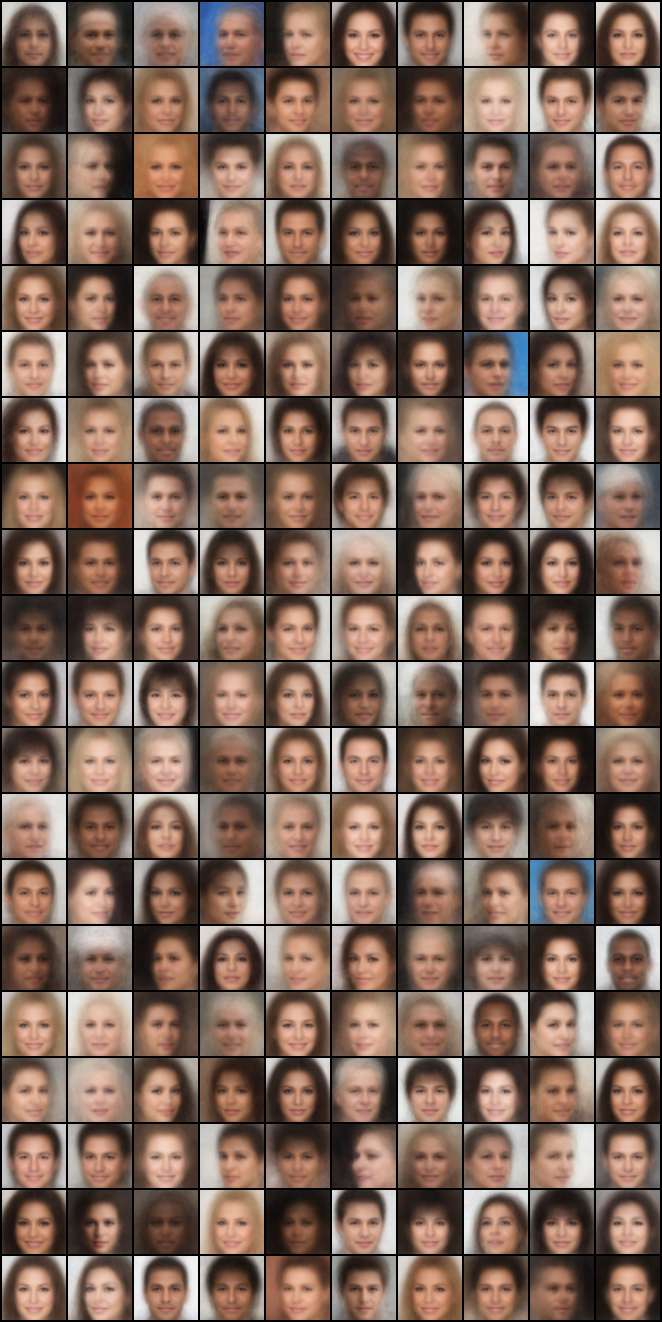

In [16]:
printImgs(centers)

In [207]:
from collections import Counter

In [208]:
Counter(y).most_common()

[(199, 200),
 (148, 197),
 (116, 194),
 (129, 192),
 (186, 192),
 (81, 191),
 (92, 191),
 (44, 190),
 (139, 190),
 (118, 189),
 (16, 181),
 (103, 173),
 (150, 173),
 (15, 172),
 (8, 170),
 (74, 168),
 (32, 166),
 (172, 165),
 (41, 162),
 (69, 157),
 (56, 156),
 (36, 155),
 (66, 154),
 (125, 152),
 (70, 151),
 (80, 151),
 (179, 148),
 (51, 144),
 (20, 143),
 (5, 142),
 (167, 142),
 (159, 139),
 (184, 139),
 (107, 138),
 (73, 137),
 (40, 136),
 (43, 132),
 (87, 132),
 (164, 132),
 (154, 131),
 (171, 128),
 (12, 127),
 (190, 126),
 (119, 125),
 (86, 124),
 (113, 124),
 (47, 123),
 (97, 122),
 (170, 122),
 (59, 121),
 (169, 121),
 (6, 119),
 (61, 119),
 (26, 118),
 (197, 118),
 (181, 117),
 (88, 116),
 (146, 116),
 (194, 116),
 (132, 115),
 (144, 115),
 (176, 115),
 (196, 115),
 (90, 114),
 (111, 114),
 (123, 114),
 (71, 113),
 (17, 112),
 (22, 112),
 (114, 111),
 (155, 111),
 (45, 110),
 (9, 108),
 (124, 108),
 (142, 108),
 (180, 108),
 (34, 106),
 (100, 106),
 (117, 106),
 (198, 106),
 (

In [209]:
import os

In [210]:
os.makedirs('data/celeba_center_200_20000/0')

FileExistsError: [Errno 17] File exists: 'data/celeba_center_200_20000/0'

In [211]:
for i, img in enumerate(centers):
    save_image(img, 'data/celeba_center_200_20000/0/{}.png'.format(i))

In [ ]:
all_imgs_20000 = all_imgs

## conv_features k-means

In [212]:
all_features = get_features(all_imgs)

100%|██████████| 200/200 [01:02<00:00,  2.98it/s]


In [213]:
X = all_features[0].view(20000, -1).numpy()

In [214]:
kmeans = KMeans(n_clusters=200, n_jobs=12)

In [215]:
%time y = kmeans.fit_predict(X)

CPU times: user 1.6 s, sys: 866 ms, total: 2.47 s
Wall time: 24 s


In [216]:
conv_centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 512).float()

In [217]:
torch.save(conv_centers, 'data/celeba_conv_center_200_20000.pth')

## logit features k-means

In [218]:
X = all_features[1].view(20000, -1).numpy()

In [219]:
kmeans = KMeans(n_clusters=200, n_jobs=12)

In [220]:
%time y = kmeans.fit_predict(X)

CPU times: user 3.23 s, sys: 1.15 s, total: 4.39 s
Wall time: 49.3 s


In [221]:
conv_centers = torch.from_numpy(kmeans.cluster_centers_).float()

In [222]:
torch.save(conv_centers, 'data/celeba_logit_center_200_20000.pth')

# Mode Collapse Plot

In [23]:
centers = torch.load('data/celeba_center_50_2000.pth')

In [24]:
centers.size()

torch.Size([50, 3, 64, 64])

In [27]:
r_imgs = all_imgs[:2000]

In [28]:
r2_imgs = all_imgs[2000:4000]

In [38]:
X = r_imgs.view(2000, -1).numpy()

In [61]:
kmeans = KMeans(n_clusters=50, n_jobs=12)

In [62]:
kmeans

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=50, n_init=10,
    n_jobs=12, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [63]:
%time y = kmeans.fit_predict(X)

CPU times: user 4.1 s, sys: 2.87 s, total: 6.98 s
Wall time: 15.7 s


In [64]:
centers = torch.from_numpy(kmeans.cluster_centers_).view(-1, 3, 64, 64).float()

In [65]:
torch.save(centers, 'data/celeba_center_50_2000.pth')

In [29]:
pred = l2dist(r_imgs, centers).min(1)[1].squeeze_()

In [67]:
Counter(pred).most_common()

[(5, 99),
 (39, 90),
 (21, 82),
 (12, 77),
 (15, 70),
 (23, 68),
 (0, 62),
 (16, 58),
 (46, 57),
 (29, 55),
 (32, 52),
 (11, 48),
 (13, 47),
 (43, 47),
 (4, 46),
 (10, 46),
 (9, 44),
 (37, 44),
 (6, 43),
 (38, 42),
 (44, 41),
 (20, 40),
 (45, 37),
 (47, 35),
 (28, 34),
 (30, 34),
 (40, 34),
 (49, 34),
 (19, 32),
 (34, 32),
 (35, 32),
 (7, 31),
 (18, 31),
 (36, 31),
 (31, 30),
 (14, 28),
 (27, 28),
 (48, 28),
 (8, 27),
 (17, 25),
 (26, 25),
 (41, 25),
 (1, 23),
 (24, 22),
 (22, 18),
 (42, 18),
 (3, 15),
 (2, 11),
 (25, 11),
 (33, 11)]

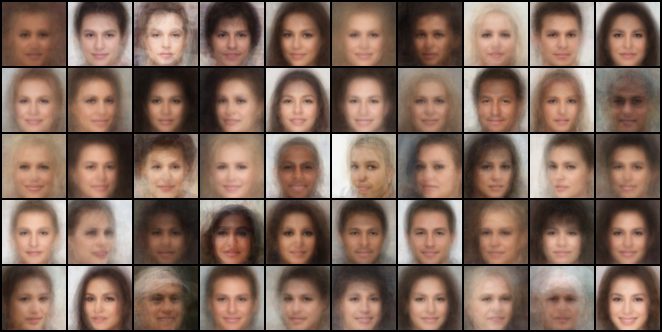

In [68]:
printImgs(centers)

In [76]:
pix_scores = collapse_score_val(r2_imgs, r_imgs, centers, pred)

0 [22.07560920715332, 0.016399843143538744, 0.4935, 0.489]
1 [21.996715545654297, 0.018065688534369122, 0.489, 0.504]
2 [21.96185302734375, 0.018502554984981438, 0.4855, 0.5085]
3 [21.883041381835938, 0.01950006848456415, 0.4845, 0.52]
4 [21.85028076171875, 0.020223043923553737, 0.485, 0.5285]
5 [21.830062866210938, 0.020537207995026924, 0.4835, 0.531]
6 [21.80708122253418, 0.02095146589578693, 0.48, 0.5365]
7 [21.756818771362305, 0.02206902087179139, 0.4785, 0.545]
8 [21.709815979003906, 0.023795097907535357, 0.4765, 0.5535]
9 [21.615428924560547, 0.026408316623853564, 0.4645, 0.57]
10 [21.557960510253906, 0.028214967152454678, 0.459, 0.582]
11 [21.496337890625, 0.030510098272431542, 0.462, 0.5875]
12 [21.46319580078125, 0.03177982857824161, 0.4635, 0.598]
13 [21.422809600830078, 0.03321074650171257, 0.461, 0.6055]
14 [21.380603790283203, 0.03427944173261132, 0.4585, 0.611]
15 [21.326129913330078, 0.035839656851540766, 0.456, 0.618]
16 [21.29175567626953, 0.036833141478221164, 0.4545,

In [77]:
torch.save(pix_scores, 'figures/celeba_mode_collapse_pixel_scores.pth')

In [78]:
pix_scores.shape

(50, 4)

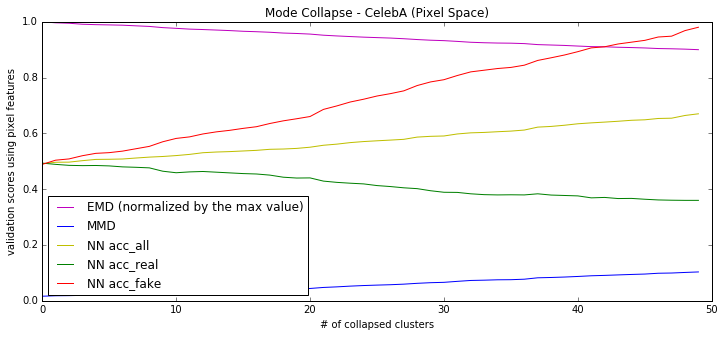

In [90]:
scores = pix_scores
val_scores = pix_scores[0, :]
f = plt.subplots(figsize=(12, 5))
plt.plot(scores[:, 0] / max(scores[:, 0]), 'm-', label='EMD (normalized by the max value)')
# plt.plot([val_scores[0] / max(scores[:, 0])] * 200, 'm--', label='emd real')
plt.plot(scores[:, 1], 'b-', label='MMD')
# plt.plot([val_scores[1]] * 200, 'b--', label='mmd real')
plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'y-', label='NN acc_all')
plt.plot(scores[:, 2], 'g-', label='NN acc_real')
# plt.plot([val_scores[2]] * 200, 'r--', label='acc_t real')
plt.plot(scores[:, 3], 'r-', label='NN acc_fake')
# plt.plot([val_scores[3]] * 200, 'g--', label='acc_f real')

plt.title('Mode Collapse - CelebA (Pixel Space)')
plt.ylabel('validation scores using pixel features')
plt.xlabel('# of collapsed clusters')
plt.legend(loc='best')

In [ ]:
scores = pix_scores
val_scores = pix_scores[0, :]
f = plt.subplots(figsize=(12, 5))
plt.plot(scores[:, 0] / max(scores[:, 0]), 'm-', label='EMD (normalized by the max value)')
# plt.plot([val_scores[0] / max(scores[:, 0])] * 200, 'm--', label='emd real')
plt.plot(scores[:, 1], 'b-', label='MMD')
# plt.plot([val_scores[1]] * 200, 'b--', label='mmd real')
plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'y-', label='NN acc_all')
plt.plot(scores[:, 2], 'g-', label='NN acc_real')
# plt.plot([val_scores[2]] * 200, 'r--', label='acc_t real')
plt.plot(scores[:, 3], 'r-', label='NN acc_fake')
# plt.plot([val_scores[3]] * 200, 'g--', label='acc_f real')

plt.title('Mode Collapse - CelebA (Pixel Space)')
plt.ylabel('validation scores using pixel features')
plt.xlabel('# of collapsed clusters')
plt.legend(loc='best')
figname = 'celeba_mode_collapse_pixel'
plt.savefig('figures/{}.pdf'.format(figname))
plt.savefig('figures/{}.eps'.format(figname))
plt.show()

In [31]:
r_feat = get_features(r_imgs)

100%|██████████| 20/20 [00:07<00:00,  2.90it/s]


In [32]:
r2_feat = get_features(r2_imgs)

100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


In [33]:
c_feat = get_features(centers)

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


In [85]:
conv_scores = collapse_score_val(r2_feat[0], r_feat[0], c_feat[0], pred)

0 [9.486135482788086, 0.015813864247297537, 0.5315, 0.485]
1 [9.523219108581543, 0.01842548037098052, 0.537, 0.4935]
2 [9.554338455200195, 0.022236534261187057, 0.5405, 0.4975]
3 [9.560832023620605, 0.027947828358961715, 0.5415, 0.502]
4 [9.583179473876953, 0.03284092869656291, 0.543, 0.505]
5 [9.601360321044922, 0.03725776429186924, 0.545, 0.5085]
6 [9.65291976928711, 0.04972092517297907, 0.558, 0.518]
7 [9.689492225646973, 0.05843771778919641, 0.5655, 0.526]
8 [9.741085052490234, 0.06361830928465996, 0.5685, 0.532]
9 [9.783838272094727, 0.07132738048129952, 0.576, 0.539]
10 [9.872584342956543, 0.08828630044574272, 0.5935, 0.553]
11 [9.93016242980957, 0.09547546402025624, 0.598, 0.5605]
12 [9.989452362060547, 0.09926679588991048, 0.6005, 0.564]
13 [10.052074432373047, 0.10993770217782116, 0.6145, 0.571]
14 [10.083647727966309, 0.11433316500452537, 0.62, 0.579]
15 [10.212522506713867, 0.13405114075948726, 0.6315, 0.5985]
16 [10.249167442321777, 0.1410933457685221, 0.637, 0.6065]
17 [10

In [86]:
torch.save(conv_scores, 'figures/celeba_mode_collapse_conv_scores.pth')

In [34]:
incept_score = collapse_inception_score(r_feat[2], c_feat[2], pred)

0 2.5402903955726046
1 2.5127402840757824
2 2.501213480522914
3 2.4912869229650503
4 2.453781214753925
5 2.4234382141060746
6 2.4073730392985113
7 2.397933488925729
8 2.3606325911574713
9 2.2991787785479145
10 2.2669672308070417
11 2.2482941259069893
12 2.2232420340041177
13 2.2038840002315014
14 2.1772179698077414
15 2.1473296856114636
16 2.13034938127217
17 2.1154908188226904
18 2.0729039428833924
19 2.0508575972044545
20 1.9897280698278859
21 1.944188025076808
22 1.9084625730253026
23 1.871410743978326
24 1.851574609452497
25 1.8287207352711607
26 1.798897713951211
27 1.7790209004166104
28 1.773098653844122
29 1.7528153961367143
30 1.7408186166403028
31 1.7167725781355114
32 1.7034117511345765
33 1.6645166303554901
34 1.6494059957641736
35 1.6561854784059369
36 1.6457595472821511
37 1.6020395908163172
38 1.5777083307639967
39 1.5575555135570123
40 1.550807016302835
41 1.5459737675347984
42 1.53283410485195
43 1.4924027484399234
44 1.4617328042717777
45 1.453666567946234
46 1.4021009

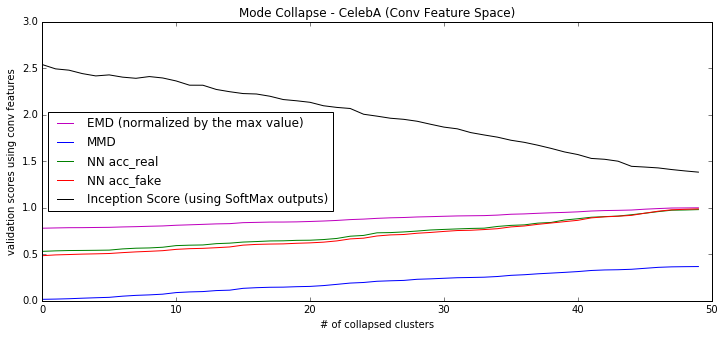

In [93]:
scores = conv_scores
val_scores = scores[0, :]
f = plt.subplots(figsize=(12, 5))
plt.plot(scores[:, 0] / max(scores[:, 0]), 'm-', label='EMD (normalized by the max value)')
# plt.plot([val_scores[0] / max(scores[:, 0])] * 200, 'm--', label='emd real')
plt.plot(scores[:, 1], 'b-', label='MMD')
# plt.plot([val_scores[1]] * 200, 'b--', label='mmd real')
# plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'y-', label='NN acc_all')
plt.plot(scores[:, 2], 'g-', label='NN acc_real')
# plt.plot([val_scores[2]] * 200, 'r--', label='acc_t real')
plt.plot(scores[:, 3], 'r-', label='NN acc_fake')
# plt.plot([val_scores[3]] * 200, 'g--', label='acc_f real')
plt.plot(incept_score, 'k-', label='Inception Score (using SoftMax outputs)')

plt.title('Mode Collapse - CelebA (Conv Feature Space)')
plt.ylabel('validation scores using conv features')
plt.xlabel('# of collapsed clusters')
plt.legend(loc='best')

## Mode Drop

In [96]:
pix_dscores = dropping_score_val(r2_imgs, r_imgs, pred)

0 [22.07560920715332, 0.018111426032006807, 0.4935, 0.489]
1 [22.114591598510742, 0.01947549796226789, 0.5025, 0.5075]
2 [22.116212844848633, 0.021266851874675873, 0.5075, 0.5165]
3 [22.107181549072266, 0.02281501580925742, 0.511, 0.5295]
4 [22.154085159301758, 0.022331072584389475, 0.517, 0.549]
5 [22.20285415649414, 0.02300328414407733, 0.5245, 0.5705]
6 [22.242019653320312, 0.025058414604573143, 0.5325, 0.591]
7 [22.295063018798828, 0.024377655923555158, 0.538, 0.611]
8 [22.328054428100586, 0.02481951391834767, 0.544, 0.6295]
9 [22.335102081298828, 0.023686822202138975, 0.549, 0.6585]
10 [22.370929718017578, 0.02363177977835627, 0.552, 0.663]
11 [22.397705078125, 0.027754120246174154, 0.5595, 0.6735]
12 [22.453960418701172, 0.029436466683839462, 0.5665, 0.7005]
13 [22.55443000793457, 0.03177385071710377, 0.572, 0.7145]
14 [22.6186466217041, 0.030726560772814594, 0.598, 0.7375]
15 [22.58039093017578, 0.03298834179341228, 0.604, 0.758]
16 [22.628896713256836, 0.03521603214482302, 0.60

In [99]:
torch.save(pix_dscores, 'figures/celeba_mode_dropping_pixel_scores.pth')

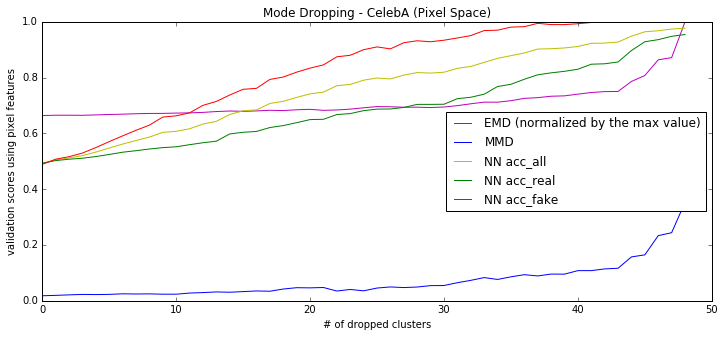

In [117]:
scores = pix_dscores
val_scores = pix_scores[0, :]
f = plt.subplots(figsize=(12, 5))
plt.plot(scores[:, 0] / max(scores[:, 0]), 'm-', label='EMD (normalized by the max value)')
# plt.plot([val_scores[0] / max(scores[:, 0])] * 200, 'm--', label='emd real')
plt.plot(scores[:, 1], 'b-', label='MMD')
# plt.plot([val_scores[1]] * 200, 'b--', label='mmd real')
plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'y-', label='NN acc_all')
plt.plot(scores[:, 2], 'g-', label='NN acc_real')
# plt.plot([val_scores[2]] * 200, 'r--', label='acc_t real')
plt.plot(scores[:, 3], 'r-', label='NN acc_fake')
# plt.plot([val_scores[3]] * 200, 'g--', label='acc_f real')

plt.title('Mode Dropping - CelebA (Pixel Space)')
plt.ylabel('validation scores using pixel features')
plt.xlabel('# of dropped clusters')
plt.legend(loc='best')
plt.show()

In [37]:
conv_dscores = dropping_score_val(r2_feat[0], r_feat[0], pred)

0 [9.486135482788086, 0.01783233173280188, 0.5315, 0.485]
1 [9.490713119506836, 0.017920939333354608, 0.534, 0.492]
2 [9.475035667419434, 0.01883059335333165, 0.5365, 0.5025]


KeyboardInterrupt: 

In [102]:
torch.save(conv_dscores, 'figures/celeba_mode_dropping_conv_scores.pth')

In [38]:
incept_dscore = drop_inception_score(r_feat[2], pred)

0 2.5402903955726046
1 2.538046432177502
2 2.5078965697305002
3 2.481786587514849
4 2.482330308762058
5 2.473683799863971
6 2.4688685749001245
7 2.461282358045322
8 2.4764716271970157
9 2.478748930947989
10 2.5031931212773606
11 2.496336161650292
12 2.482324981876397
13 2.497074049287163
14 2.5220698974914573
15 2.510669964372325
16 2.481360062811151
17 2.505801423795481
18 2.4691589132781715
19 2.468375624603455
20 2.4634754616701686
21 2.4679578493637297
22 2.437010764817218
23 2.4363528647535766
24 2.467080784126452
25 2.450710002977701
26 2.4273254164640723
27 2.52654785557621
28 2.440690266482812
29 2.4282460458176693
30 2.4075449091111456
31 2.394591357283407
32 2.4508780538034833
33 2.4796234425401305
34 2.579067666221784
35 2.6172698470389233
36 2.6600603770997013
37 2.7075826107136787
38 2.4929824661936655
39 2.6147912372294617
40 2.6362084104304393
41 2.5950379851922687
42 2.5342353088346923
43 2.573377514581862
44 2.639030286710018
45 2.689997853330784
46 2.6658062498935085


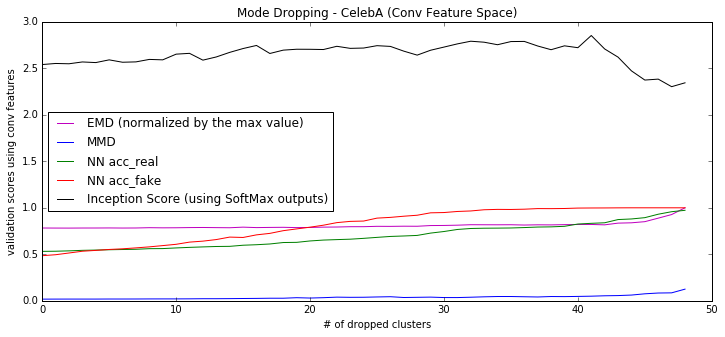

In [128]:
scores = conv_dscores
val_scores = scores[0, :]
f = plt.subplots(figsize=(12, 5))
plt.plot(scores[:, 0] / max(scores[:, 0]), 'm-', label='EMD (normalized by the max value)')
# plt.plot([val_scores[0] / max(scores[:, 0])] * 200, 'm--', label='emd real')
plt.plot(scores[:, 1], 'b-', label='MMD')
# plt.plot([val_scores[1]] * 200, 'b--', label='mmd real')
# plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'y-', label='NN acc_all')
plt.plot(scores[:, 2], 'g-', label='NN acc_real')
# plt.plot([val_scores[2]] * 200, 'r--', label='acc_t real')
plt.plot(scores[:, 3], 'r-', label='NN acc_fake')
# plt.plot([val_scores[3]] * 200, 'g--', label='acc_f real')
plt.plot(incept_dscore, 'k-', label='Inception Score (using SoftMax outputs)')

plt.title('Mode Dropping - CelebA (Conv Feature Space)')
plt.ylabel('validation scores using conv features')
plt.xlabel('# of dropped clusters')
plt.legend(loc='best')
plt.show()

In [ ]:
torch.save(incept_score, 'figures/celeba_mode_collapse_inception_scores.pth')
torch.save(incept_dscore, 'figures/celeba_mode_dropping_inception_scores.pth')

## Overfitting experiment

In [44]:
overfit = overfitting_score_val(r2_imgs, r_imgs)

0 [22.07560920715332, 0.018111426032006807, 0.4935, 0.489]
1 [19.979827880859375, 0.017130900765996906, 0.4445, 0.4535]
2 [17.859251022338867, 0.01601005569573161, 0.403, 0.4145]
3 [15.771991729736328, 0.015337447964118374, 0.352, 0.373]
4 [13.61046314239502, 0.013348092008132372, 0.293, 0.3145]
5 [11.449178695678711, 0.012559201214281654, 0.2475, 0.275]
6 [9.30844497680664, 0.012357346711303598, 0.1925, 0.223]
7 [7.094925403594971, 0.0101800409227874, 0.144, 0.1625]
8 [4.850705146789551, 0.009005061816445309, 0.0925, 0.1005]
9 [2.6015520095825195, 0.0061538205375621016, 0.0515, 0.0505]
10 [0.15333051979541779, 0.0, 0.001, 0.0005]


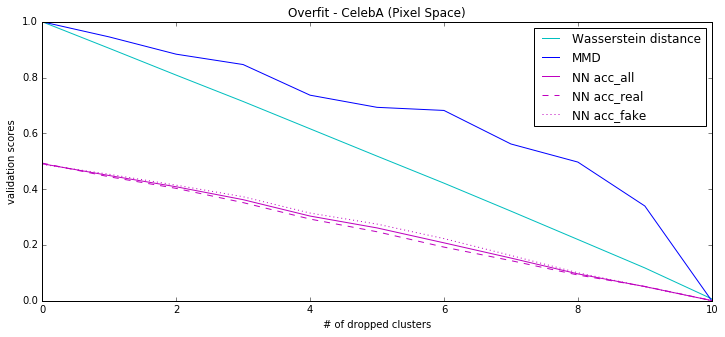

In [47]:
scores = overfit
f = plt.subplots(figsize=(12, 5))
plt.plot(scores[:, 0] / max(scores[:, 0]), 'c-', label='Wasserstein distance')
plt.plot(scores[:, 1] / max(scores[:, 1]), 'b-', label='MMD')
plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'm-', label='NN acc_all')
plt.plot(scores[:, 2], 'm--', label='NN acc_real')
plt.plot(scores[:, 3], 'm:', label='NN acc_fake')

plt.title('Overfit - CelebA (Pixel Space)')
plt.ylabel('validation scores')
plt.xlabel('# of dropped clusters')
plt.legend(loc='best')
plt.show()

In [50]:
overfit_conv = overfitting_score_val(r2_feat[0], r_feat[0])

0 [9.486135482788086, 0.01783233173280188, 0.5315, 0.485]
1 [8.577047348022461, 0.016844603222748993, 0.478, 0.43]
2 [7.667879581451416, 0.01633805026736433, 0.4175, 0.3875]
3 [6.766963958740234, 0.015464985438514649, 0.3695, 0.3255]
4 [5.833152770996094, 0.0144265367003873, 0.3165, 0.278]
5 [4.9009504318237305, 0.013334448493819335, 0.2565, 0.2365]
6 [3.969480514526367, 0.012143280409655772, 0.2085, 0.203]
7 [3.019751787185669, 0.01109752727596279, 0.1545, 0.1515]
8 [2.0369772911071777, 0.00914849677503298, 0.1, 0.099]
9 [1.064791202545166, 0.006058815003331282, 0.051, 0.056]
10 [0.014690353535115719, 0.0, 0.0005, 0.0005]


In [77]:
overfit_incept = overfit_inception_score(r2_feat[2], r_feat[2])

0 2.5402903955726046
1 2.5677783070904256
2 2.5605131903697336
3 2.564315177484775
4 2.572472385505768
5 2.560842164703473
6 2.5884288825513
7 2.603395242097579
8 2.583978244704215
9 2.552720728883365
10 2.5315239603277213


In [82]:
torch.save([overfit, overfit_conv, overfit_incept], 'data/celeba_overfit.pth')

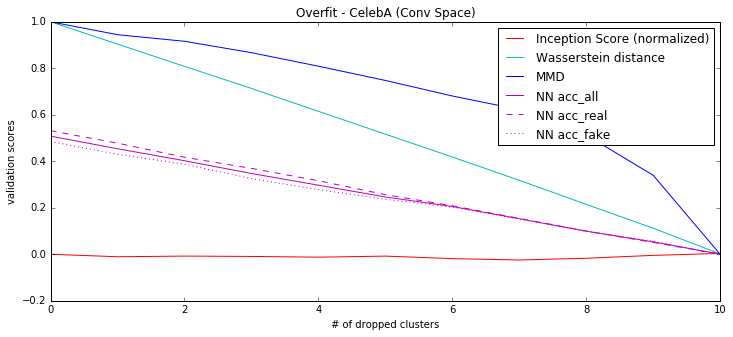

In [78]:
scores = overfit_conv
f = plt.subplots(figsize=(12, 5))
plt.plot(np.linspace(0, 1, 11), (1 - overfit_incept / 2.541), 'r-', label='Inception Score (normalized)')
plt.plot(np.linspace(0, 1, 11), scores[:, 0] / max(scores[:, 0]), 'c-', label='Wasserstein distance')
plt.plot(np.linspace(0, 1, 11), scores[:, 1] / max(scores[:, 1]), 'b-', label='MMD')
plt.plot((scores[:, 2] + scores[:, 3]) / 2, 'm-', label='NN acc_all')
plt.plot(scores[:, 2], 'm--', label='NN acc_real')
plt.plot(scores[:, 3], 'm:', label='NN acc_fake')

plt.title('Overfit - CelebA (Conv Space)')
plt.ylabel('validation scores')
plt.xlabel('# ')
plt.legend(loc='best')

In [75]:
overfit_incept

array([[ 2.5402904 ,  2.5402904 ,  2.5402904 ,  2.5402904 ],
       [ 2.56777831,  2.56777831,  2.56777831,  2.56777831],
       [ 2.56051319,  2.56051319,  2.56051319,  2.56051319],
       [ 2.56431518,  2.56431518,  2.56431518,  2.56431518],
       [ 2.57247239,  2.57247239,  2.57247239,  2.57247239],
       [ 2.56084216,  2.56084216,  2.56084216,  2.56084216],
       [ 2.58842888,  2.58842888,  2.58842888,  2.58842888],
       [ 2.60339524,  2.60339524,  2.60339524,  2.60339524],
       [ 2.58397824,  2.58397824,  2.58397824,  2.58397824],
       [ 2.55272073,  2.55272073,  2.55272073,  2.55272073],
       [ 2.53152396,  2.53152396,  2.53152396,  2.53152396]])

In [83]:
lsun = datasets.LSUN(db_path='data/lsun', classes=['bedroom_train'],
                        transform=transforms.Compose([
                            transforms.Scale(64),
                            transforms.CenterCrop(64),
                            transforms.ToTensor(),
#                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))

In [84]:
# real_idx = torch.randperm(len(lsun)).long()[:20000]

In [85]:
# torch.save(real_idx, 'data/lsun_20000_real_idx.pth')

In [86]:
real_idx = torch.load('data/lsun_20000_real_idx.pth')

In [89]:
r_imgs = torch.stack([lsun[i][0] for i in tqdm(real_idx[:2000])], 0)



  0%|          | 0/2000 [00:00<?, ?it/s]

  2%|▏         | 46/2000 [00:00<00:04, 454.25it/s]

  4%|▍         | 90/2000 [00:00<00:04, 447.95it/s]

  7%|▋         | 138/2000 [00:00<00:04, 455.08it/s]

  9%|▉         | 186/2000 [00:00<00:03, 459.52it/s]

 12%|█▏        | 232/2000 [00:00<00:03, 458.37it/s]

 14%|█▍        | 281/2000 [00:00<00:03, 465.16it/s]

 16%|█▋        | 329/2000 [00:00<00:03, 467.04it/s]

 19%|█▉        | 376/2000 [00:00<00:03, 465.09it/s]

 21%|██        | 422/2000 [00:00<00:03, 462.58it/s]

 24%|██▎       | 470/2000 [00:01<00:03, 467.00it/s]


 26%|██▌       | 516/2000 [00:01<00:03, 373.61it/s]

 28%|██▊       | 563/2000 [00:01<00:03, 398.09it/s]

 31%|███       | 612/2000 [00:01<00:03, 420.68it/s]

 33%|███▎      | 660/2000 [00:01<00:03, 436.32it/s]

 35%|███▌      | 707/2000 [00:01<00:02, 444.60it/s]

 38%|███▊      | 756/2000 [00:01<00:02, 456.76it/s]

 40%|████      | 804/2000 [00:01<00:02, 460.56it/s]

 43%|████▎     | 853/2000 [00:01<00:02, 467.71it/s]

 45

In [90]:
r2_imgs = torch.stack([lsun[i][0] for i in tqdm(real_idx[2000:4000])], 0)



  0%|          | 0/2000 [00:00<?, ?it/s]

  2%|▏         | 45/2000 [00:00<00:04, 442.09it/s]

  5%|▍         | 92/2000 [00:00<00:04, 448.90it/s]

  7%|▋         | 141/2000 [00:00<00:04, 459.37it/s]

  9%|▉         | 186/2000 [00:00<00:03, 456.47it/s]

 12%|█▏        | 232/2000 [00:00<00:03, 456.18it/s]

 14%|█▍        | 279/2000 [00:00<00:03, 459.15it/s]

 16%|█▋        | 327/2000 [00:00<00:03, 464.99it/s]

 19%|█▊        | 374/2000 [00:00<00:03, 464.41it/s]

 21%|██        | 422/2000 [00:00<00:03, 466.29it/s]

 24%|██▎       | 470/2000 [00:01<00:03, 467.67it/s]

 26%|██▌       | 517/2000 [00:01<00:03, 465.78it/s]

 28%|██▊       | 565/2000 [00:01<00:03, 467.63it/s]

 31%|███       | 614/2000 [00:01<00:02, 471.75it/s]

 33%|███▎      | 662/2000 [00:01<00:02, 472.54it/s]

 35%|███▌      | 709/2000 [00:01<00:02, 468.80it/s]

 38%|███▊      | 757/2000 [00:01<00:02, 470.31it/s]

 40%|████      | 804/2000 [00:01<00:02, 470.16it/s]

 43%|████▎     | 852/2000 [00:01<00:02, 470.46it/s]

 45%

In [91]:
r_feat = get_features(r_imgs)



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:06,  3.06it/s]

 10%|█         | 2/20 [00:00<00:05,  3.16it/s]

 15%|█▌        | 3/20 [00:00<00:05,  3.24it/s]

 20%|██        | 4/20 [00:01<00:04,  3.30it/s]

 25%|██▌       | 5/20 [00:01<00:04,  3.34it/s]

 30%|███       | 6/20 [00:01<00:04,  3.37it/s]

 35%|███▌      | 7/20 [00:02<00:03,  3.40it/s]

 40%|████      | 8/20 [00:02<00:03,  3.41it/s]

 45%|████▌     | 9/20 [00:02<00:03,  3.42it/s]

 50%|█████     | 10/20 [00:02<00:02,  3.43it/s]

 55%|█████▌    | 11/20 [00:03<00:02,  3.43it/s]

 60%|██████    | 12/20 [00:03<00:02,  3.44it/s]

 65%|██████▌   | 13/20 [00:03<00:02,  3.43it/s]

 70%|███████   | 14/20 [00:04<00:01,  3.43it/s]

 75%|███████▌  | 15/20 [00:04<00:01,  3.42it/s]

 80%|████████  | 16/20 [00:04<00:01,  3.41it/s]

 85%|████████▌ | 17/20 [00:04<00:00,  3.41it/s]

 90%|█████████ | 18/20 [00:05<00:00,  3.42it/s]

 95%|█████████▌| 19/20 [00:05<00:00,  3.42it/s]

100%|██████████| 20/20 [00:05<00:00,

In [92]:
r2_feat = get_features(r2_imgs)



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:05,  3.27it/s]

 10%|█         | 2/20 [00:00<00:05,  3.30it/s]

 15%|█▌        | 3/20 [00:00<00:05,  3.35it/s]

 20%|██        | 4/20 [00:01<00:04,  3.38it/s]

 25%|██▌       | 5/20 [00:01<00:04,  3.38it/s]

 30%|███       | 6/20 [00:01<00:04,  3.39it/s]

 35%|███▌      | 7/20 [00:02<00:03,  3.40it/s]

 40%|████      | 8/20 [00:02<00:03,  3.41it/s]

 45%|████▌     | 9/20 [00:02<00:03,  3.41it/s]

 50%|█████     | 10/20 [00:02<00:02,  3.43it/s]

 55%|█████▌    | 11/20 [00:03<00:02,  3.43it/s]

 60%|██████    | 12/20 [00:03<00:02,  3.44it/s]

 65%|██████▌   | 13/20 [00:03<00:02,  3.44it/s]

 70%|███████   | 14/20 [00:04<00:01,  3.41it/s]

 75%|███████▌  | 15/20 [00:04<00:01,  3.39it/s]

 80%|████████  | 16/20 [00:04<00:01,  3.38it/s]

 85%|████████▌ | 17/20 [00:05<00:00,  3.36it/s]

 90%|█████████ | 18/20 [00:05<00:00,  3.36it/s]

 95%|█████████▌| 19/20 [00:05<00:00,  3.35it/s]

100%|██████████| 20/20 [00:05<00:00,

In [93]:
overfit = overfitting_score_val(r2_imgs, r_imgs)

0 [25.437406539916992, 0.01787190947000104, 0.4855, 0.4875]
1 [22.9532470703125, 0.01694042478932904, 0.4425, 0.4375]
2 [20.512842178344727, 0.015547271707644443, 0.3845, 0.3895]
3 [18.082094192504883, 0.014806182837646484, 0.3455, 0.353]
4 [15.604252815246582, 0.013708511435138864, 0.289, 0.303]
5 [13.122369766235352, 0.012873636411364568, 0.2375, 0.261]
6 [10.657139778137207, 0.0117522309955038, 0.1805, 0.203]
7 [8.070147514343262, 0.010256503924536765, 0.1395, 0.1545]
8 [5.502998352050781, 0.008486087793921663, 0.098, 0.1075]
9 [2.915494918823242, 0.005797446397570864, 0.0445, 0.056]
10 [0.15982133150100708, 0.0, 0.0, 0.0]


In [94]:
overfit_conv = overfitting_score_val(r2_feat[0], r_feat[0])

0 [14.971071243286133, 0.01991229141323845, 0.5195, 0.484]
1 [13.512947082519531, 0.01904980198805544, 0.463, 0.434]
2 [12.066544532775879, 0.01793507113610751, 0.405, 0.3825]
3 [10.60318374633789, 0.017046301001651755, 0.3585, 0.342]
4 [9.129779815673828, 0.015621618207216286, 0.298, 0.294]
5 [7.660201072692871, 0.014110676456180424, 0.2475, 0.2395]
6 [6.18702507019043, 0.012271040775308856, 0.195, 0.202]
7 [4.6862311363220215, 0.01064234479514081, 0.153, 0.138]
8 [3.1686465740203857, 0.008403113762171656, 0.105, 0.0965]
9 [1.6415044069290161, 0.006217400218645639, 0.0545, 0.048]
10 [0.018159912899136543, 0.0, 0.0, 0.0]


In [95]:
overfit_incept = overfit_inception_score(r2_feat[2], r_feat[2])

0 3.217189686752955
1 3.20479510737515
2 3.2417820830837596
3 3.242162008518186
4 3.2505403179374333
5 3.245648143535857
6 3.2537088854531553
7 3.2685626689233778
8 3.246823252897592
9 3.26169703928215
10 3.2733383974732555


In [96]:
torch.save([overfit, overfit_conv, overfit_incept], 'data/lsun_overfit.pth')

In [97]:
inception_score(r_feat[2])

3.2171896867529548

In [99]:
inception_score(r2_feat[2])

3.2733383974732555

In [100]:
tmp_idx = torch.randperm(len(lsun)).long()[:2000]
r3_imgs = torch.stack([lsun[i][0] for i in tqdm(tmp_idx)], 0)



  0%|          | 0/2000 [00:00<?, ?it/s]

  2%|▏         | 36/2000 [00:00<00:05, 356.08it/s]

  4%|▍         | 75/2000 [00:00<00:05, 364.12it/s]

  6%|▌         | 113/2000 [00:00<00:05, 368.72it/s]

  8%|▊         | 152/2000 [00:00<00:04, 372.28it/s]

  9%|▉         | 189/2000 [00:00<00:04, 371.23it/s]

 11%|█▏        | 227/2000 [00:00<00:04, 372.10it/s]

 13%|█▎        | 265/2000 [00:00<00:04, 373.21it/s]

 15%|█▌        | 304/2000 [00:00<00:04, 375.22it/s]

 17%|█▋        | 340/2000 [00:00<00:04, 368.86it/s]

 19%|█▉        | 378/2000 [00:01<00:04, 370.75it/s]

 21%|██        | 415/2000 [00:01<00:04, 365.83it/s]

 23%|██▎       | 452/2000 [00:01<00:04, 364.52it/s]

 24%|██▍       | 488/2000 [00:01<00:04, 358.45it/s]

 26%|██▋       | 526/2000 [00:01<00:04, 362.93it/s]

 28%|██▊       | 564/2000 [00:01<00:03, 365.83it/s]

 30%|███       | 601/2000 [00:01<00:03, 362.38it/s]

 32%|███▏      | 639/2000 [00:01<00:03, 366.21it/s]

 34%|███▍      | 677/2000 [00:01<00:03, 368.34it/s]

 36%

In [ ]:
r3_imgs

In [106]:
r3_feat = get_features(r3_imgs.add_(-0.5).mul(2)
print(inception_score(r3_feat[2]))



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:05,  3.28it/s]

 10%|█         | 2/20 [00:00<00:05,  3.30it/s]

 15%|█▌        | 3/20 [00:00<00:05,  3.31it/s]

 20%|██        | 4/20 [00:01<00:04,  3.32it/s]

 25%|██▌       | 5/20 [00:01<00:04,  3.33it/s]

 30%|███       | 6/20 [00:01<00:04,  3.33it/s]

 35%|███▌      | 7/20 [00:02<00:03,  3.32it/s]

 40%|████      | 8/20 [00:02<00:03,  3.32it/s]

 45%|████▌     | 9/20 [00:02<00:03,  3.33it/s]

 50%|█████     | 10/20 [00:03<00:02,  3.34it/s]

 55%|█████▌    | 11/20 [00:03<00:02,  3.34it/s]

 60%|██████    | 12/20 [00:03<00:02,  3.34it/s]

 65%|██████▌   | 13/20 [00:03<00:02,  3.34it/s]

 70%|███████   | 14/20 [00:04<00:01,  3.33it/s]

 75%|███████▌  | 15/20 [00:04<00:01,  3.34it/s]

 80%|████████  | 16/20 [00:04<00:01,  3.33it/s]

 85%|████████▌ | 17/20 [00:05<00:00,  3.32it/s]

 90%|█████████ | 18/20 [00:05<00:00,  3.33it/s]

 95%|█████████▌| 19/20 [00:05<00:00,  3.30it/s]

100%|██████████| 20/20 [00:06<00:00,

4.34691331453


In [172]:
debug_imgs = torch.load('/home/gh349/gan/data/features/celeba/true_resnet34_imgs.pth')

In [173]:
debug_smax = torch.load('/home/gh349/gan/data/features/celeba/true_resnet34_smax.pth')

In [109]:
debug_imgs.min()

-2.1179039478302

In [110]:
debug_imgs.size()

torch.Size([20000, 3, 224, 224])

In [111]:
dm = debug_imgs[:2000].clone()

In [ ]:
(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [113]:
dm[:, 0] = dm[:, 0] * 0.229 + 0.485
dm[:, 1] = dm[:, 1] * 0.224 + 0.456
dm[:, 2] = dm[:, 2] * 0.225 + 0.406

In [141]:
dm_feat = get_features(debug_imgs[:100])



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.60it/s]



In [142]:
dm_feat[2].norm()

6.726237296040382

In [143]:
debug_smax[:100].norm()

3.2802539096743146

In [118]:
inception_score(dm_feat[2])

2.454968249861786

In [114]:
inception_score(debug_smax[:2000])

2.4528005756836451